In [3]:
import torch
import numpy as np
from torch_geometric.utils import to_edge_index
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import snf

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def print_hist(edge_attr):
    plt.hist(edge_attr, log=True, ec="black")
    plt.xlabel("Normalised distance value")
    plt.ylabel("Counts (log)")
    plt.show()


def min_max_normalisation(X):
    return (X - X.min()) / (X.max() - X.min())

def get_edge_index(X, threshold=0.005, N_largest=None):
    if N_largest:
        idx = np.argpartition(X.ravel(), -N_largest * 2)[-N_largest * 2 :]
        threshold = X.ravel()[idx].min()

    if threshold:
        X[X < threshold] = 0

    return to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))

def get_omics(data_path):
    df = pd.read_csv(data_path, header=0, index_col=None)
    df.sort_values(by="Sample_ID", ascending=True, inplace=True)
    return df.iloc[:, 1:].values.astype(np.float64)

def print_graph(edge_index, color_labels):
    G = nx.Graph()
    G.add_nodes_from(sorted(np.unique(edge_index.flatten())))
    
    edges = [(int(e[0]), int(e[1])) for e in zip(edge_index[0], edge_index[1])]
    G.add_edges_from(edges)

    # G = nx.Graph()
    # G.add_nodes_from(sorted(H.nodes(data=True)))
    # G.add_edges_from(H.edges(data=True))

    # node_pos=nx.spring_layout(G)
    node_pos=nx.kamada_kawai_layout(G)

    nx.draw_networkx_nodes(G,node_pos,
        node_color=color_labels[np.array(G.nodes())].tolist(),
        node_size=12)
    nx.draw_networkx_edges(G, node_pos, alpha=0.25,width=1)

    print("Total number of nodes: ", int(G.number_of_nodes()))
    print("Number of isolated nodes: ", nx.number_of_isolates(G))
    print("Total number of edges: ", int(G.number_of_edges()))
    print("Min Degree for all nodes: ", np.array(G.degree())[:, 1].min())
    print("Max Degree for all nodes: ", np.array(G.degree())[:, 1].max())
    print("Mean Degree for all nodes: ", np.array(G.degree())[:, 1].mean())
    print("Total number of self-loops: ", int(nx.number_of_selfloops(G)))

    return G

gt_data = pd.read_csv("./data/gt_data.csv")
labels = np.array(gt_data["Pam50 Subtype"]).tolist()

color_codes = {
    "LumA": "tab:green",
    "LumB": "tab:red",
    "Basal": "tab:blue",
    "Her2": "tab:orange",
    "Normal": "tab:black"}

color_labels = np.array([color_codes[l] for l in labels])

Total number of nodes:  234
Number of isolated nodes:  0
Total number of edges:  422
Min Degree for all nodes:  1
Max Degree for all nodes:  18
Mean Degree for all nodes:  3.606837606837607
Total number of self-loops:  0


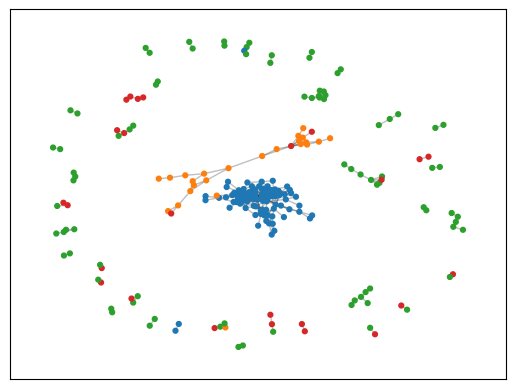

In [23]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj)
print_graph(edge_index, color_labels)

Total number of nodes:  358
Number of isolated nodes:  0
Total number of edges:  1000
Min Degree for all nodes:  1
Max Degree for all nodes:  31
Mean Degree for all nodes:  5.58659217877095
Total number of self-loops:  0


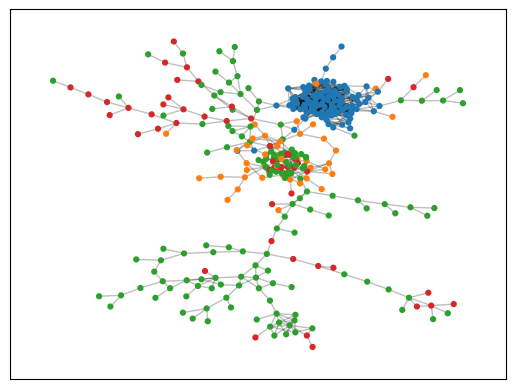

In [32]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, N_largest=1000)
print_graph(edge_index, color_labels)

Total number of nodes:  479
Number of isolated nodes:  0
Total number of edges:  2500
Min Degree for all nodes:  1
Max Degree for all nodes:  58
Mean Degree for all nodes:  10.438413361169102
Total number of self-loops:  0


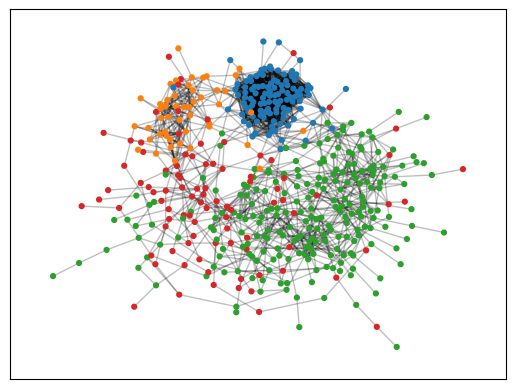

In [33]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, N_largest=2500)
print_graph(edge_index, color_labels)

Total number of nodes:  501
Number of isolated nodes:  0
Total number of edges:  5000
Min Degree for all nodes:  1
Max Degree for all nodes:  86
Mean Degree for all nodes:  19.960079840319363
Total number of self-loops:  0


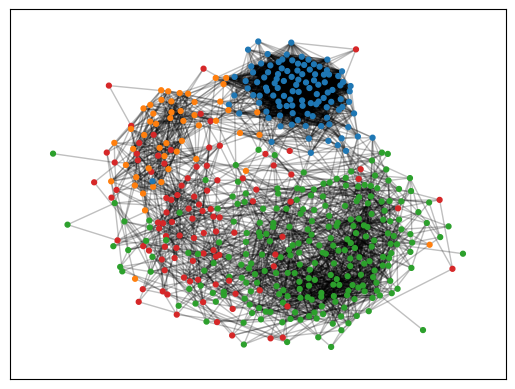

In [34]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, N_largest=5000)
print_graph(edge_index, color_labels)

Total number of nodes:  502
Number of isolated nodes:  0
Total number of edges:  5000
Min Degree for all nodes:  1
Max Degree for all nodes:  64
Mean Degree for all nodes:  19.9203187250996
Total number of self-loops:  0


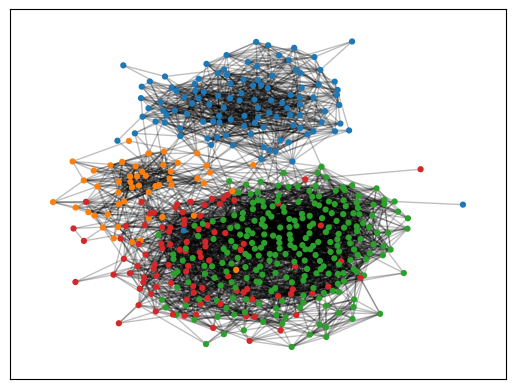

In [35]:
latent_df = pd.read_csv("./data/latent_data.csv")
data_x = latent_df.iloc[:, 1:].values

adj = snf.make_affinity(data_x, metric="sqeuclidean")
np.fill_diagonal(adj, 0)

edge_index, edge_attr = get_edge_index(adj, N_largest=5000)
print_graph(edge_index, color_labels)

In [94]:
CNV_path = "./data/MoGCN_data/gistic_data.csv"

cnv = get_omics(CNV_path)
snf_cnv = snf.make_affinity(cnv, metric="jaccard")
np.fill_diagonal(snf_cnv,0)

Total number of nodes:  298
Number of isolated nodes:  0
Total number of edges:  7000
Max Degree for all nodes:  125
Total number of self-loops:  0


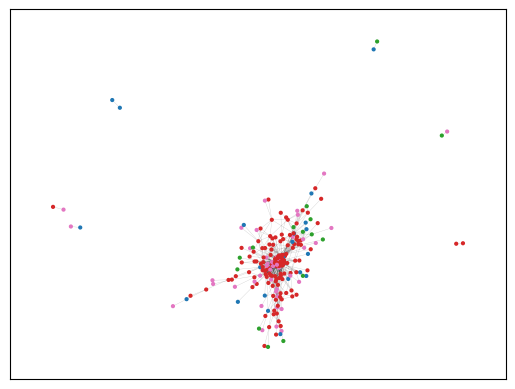

In [95]:
temp = snf_cnv.copy()
edge_index, edge_attr = get_edge_index(temp, N_largest=7000)
print_graph(edge_index, color_labels)

In [50]:
def select_max(row, n_max):
    idx = np.argpartition(row, -n_max)[-n_max:]
    new_row = np.zeros(len(row))
    new_row[idx] = 1
    return new_row



def get_edge_index(X, n_max=None, mode="max"):
    if n_max == 0:
        X = np.eye(X.shape[0], dtype=int)
        return to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))

    if mode == "max":
        threshold = 0.005
        if n_max is not None:
            threshold = np.sort(np.triu(X).ravel())[-n_max:].min()

        X[X < threshold] = 0
    else:
        X = np.apply_along_axis(select_max, 1, X, n_max)

    return to_edge_index((torch.tensor(X, dtype=torch.float).to_sparse()))

1509
Total number of nodes:  503
Number of isolated nodes:  0
Total number of edges:  1057
Min Degree for all nodes:  3
Max Degree for all nodes:  12
Mean Degree for all nodes:  4.202783300198807
Total number of self-loops:  0


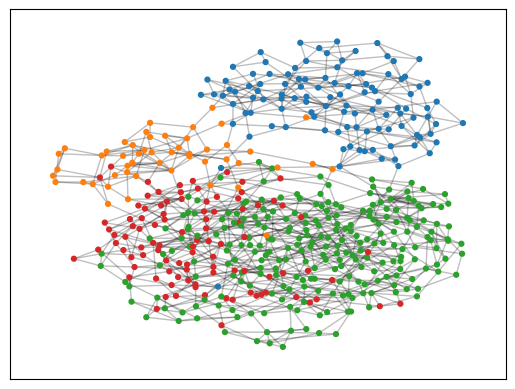

In [63]:
adj = pd.read_csv("./data/snf_latent_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, n_max=3, mode="fix")
print(len(edge_index[1]))
print_graph(edge_index, color_labels)

1509
Total number of nodes:  503
Number of isolated nodes:  0
Total number of edges:  1071
Min Degree for all nodes:  3
Max Degree for all nodes:  13
Mean Degree for all nodes:  4.258449304174951
Total number of self-loops:  0


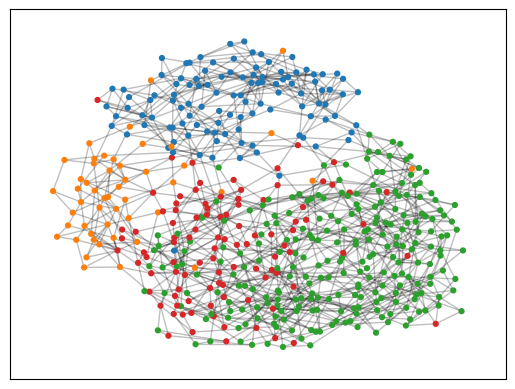

In [64]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, n_max=3, mode="fix")
print(len(edge_index[1]))
print_graph(edge_index, color_labels)

3521
Total number of nodes:  503
Number of isolated nodes:  0
Total number of edges:  2302
Min Degree for all nodes:  7
Max Degree for all nodes:  18
Mean Degree for all nodes:  9.153081510934394
Total number of self-loops:  0


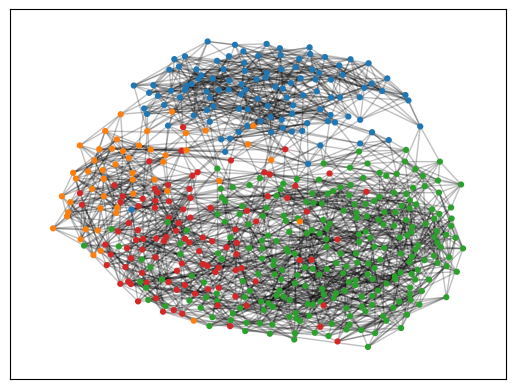

In [59]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, n_max=7, mode="fix")
print(len(edge_index[1]))
print_graph(edge_index, color_labels)

7545
Total number of nodes:  503
Number of isolated nodes:  0
Total number of edges:  4769
Min Degree for all nodes:  15
Max Degree for all nodes:  40
Mean Degree for all nodes:  18.962226640159045
Total number of self-loops:  0


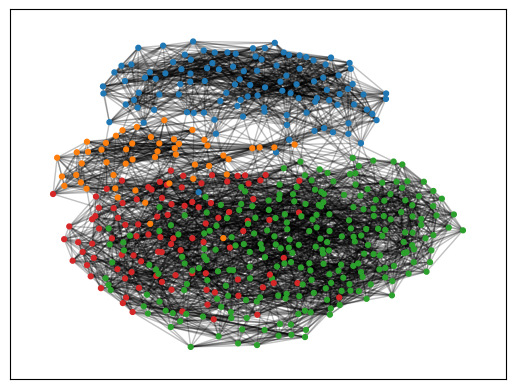

In [65]:
adj = pd.read_csv("./data/snf_latent_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, n_max=15, mode="fix")
print(len(edge_index[1]))
print_graph(edge_index, color_labels)

7545
Total number of nodes:  503
Number of isolated nodes:  0
Total number of edges:  4665
Min Degree for all nodes:  15
Max Degree for all nodes:  32
Mean Degree for all nodes:  18.548707753479125
Total number of self-loops:  0


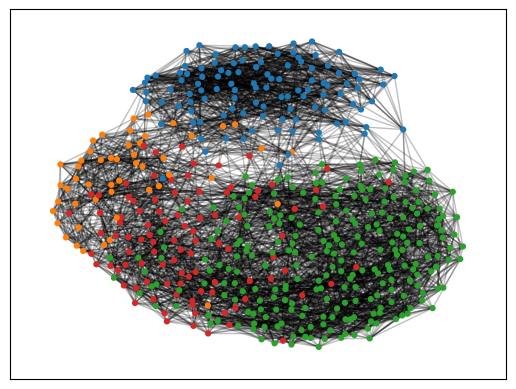

In [61]:
adj = pd.read_csv("./data/snf_data.csv", header=None).values

edge_index, edge_attr = get_edge_index(adj, n_max=15, mode="fix")
print(len(edge_index[1]))
print_graph(edge_index, color_labels)